"Compare LSTM implementations on the IMDB sentiment classification task.\n\nconsume_less='cpu' preprocesses input to the LSTM which typically results in\nfaster computations at the expense of increased peak memory usage as the\npreprocessed input must be kept in memory.\n\nconsume_less='mem' does away with the preprocessing, meaning that it might take\na little longer, but should require less peak memory.\n\nconsume_less='gpu' concatenates the input, output and forget gate's weights\ninto one, large matrix, resulting in faster computation time as the GPU can\nutilize more cores, at the expense of reduced regularization because the same\ndropout is shared across the gates.\n\nNote that the relative performance of the different `consume_less` modes\ncan vary depending on your device, your model and the size of your data.\n"

Using TensorFlow backend.


Loading data...
Testing mode: consume_less="cpu"


/home/fehiepsi/miniconda3/envs/pydata/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 48s - loss: 0.5698 - acc: 0.6966 - val_loss: 0.3933 - val_acc: 0.8230
Epoch 2/10
25000/25000 [==============================] - 44s - loss: 0.3874 - acc: 0.8306 - val_loss: 0.4069 - val_acc: 0.8285
Epoch 3/10
25000/25000 [==============================] - 44s - loss: 0.3267 - acc: 0.8636 - val_loss: 0.3745 - val_acc: 0.8363
Epoch 4/10
25000/25000 [==============================] - 44s - loss: 0.2713 - acc: 0.8898 - val_loss: 0.3978 - val_acc: 0.8274
Epoch 5/10
25000/25000 [==============================] - 44s - loss: 0.2331 - acc: 0.9089 - val_loss: 0.4437 - val_acc: 0.8307
Epoch 6/10
25000/25000 [==============================] - 44s - loss: 0.1967 - acc: 0.9220 - val_loss: 0.4935 - val_acc: 0.8156
Epoch 7/10
25000/25000 [==============================] - 44s - loss: 0.1651 - acc: 0.9358 - val_loss: 0.5088 - val_acc: 0.8237
Epoch 8/10
25000/25000 [==============================

<Container object of 3 artists>

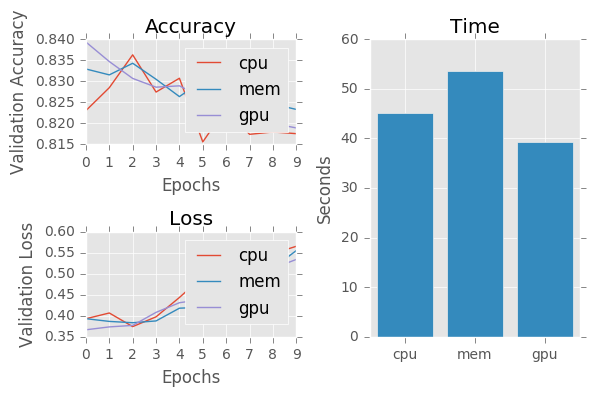

In [1]:
'''Compare LSTM implementations on the IMDB sentiment classification task.

consume_less='cpu' preprocesses input to the LSTM which typically results in
faster computations at the expense of increased peak memory usage as the
preprocessed input must be kept in memory.

consume_less='mem' does away with the preprocessing, meaning that it might take
a little longer, but should require less peak memory.

consume_less='gpu' concatenates the input, output and forget gate's weights
into one, large matrix, resulting in faster computation time as the GPU can
utilize more cores, at the expense of reduced regularization because the same
dropout is shared across the gates.

Note that the relative performance of the different `consume_less` modes
can vary depending on your device, your model and the size of your data.
'''
import time
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.datasets import imdb

max_features = 20000
max_length = 80
embedding_dim = 256
batch_size = 128
epochs = 10
modes = ['cpu', 'mem', 'gpu']

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=max_features)
X_train = sequence.pad_sequences(X_train, max_length)
X_test = sequence.pad_sequences(X_test, max_length)

# Compile and train different models while meauring performance.
results = []
for mode in modes:
    print('Testing mode: consume_less="{}"'.format(mode))

    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=max_length, dropout=0.2))
    model.add(LSTM(embedding_dim, dropout_W=0.2, dropout_U=0.2, consume_less=mode))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        nb_epoch=epochs,
                        validation_data=(X_test, y_test))
    average_time_per_epoch = (time.time() - start_time) / epochs

    results.append((history, average_time_per_epoch))

# Compare models' accuracy, loss and elapsed time per epoch.
plt.style.use('ggplot')
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.set_title('Accuracy')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xlabel('Epochs')
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax2.set_title('Loss')
ax2.set_ylabel('Validation Loss')
ax2.set_xlabel('Epochs')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax3.set_title('Time')
ax3.set_ylabel('Seconds')
for mode, result in zip(modes, results):
    ax1.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
ax1.legend()
ax2.legend()
ax3.bar(np.arange(len(results)), [x[1] for x in results],
        tick_label=modes, align='center')
plt.tight_layout()
plt.show()